<a href="https://colab.research.google.com/github/fmarsico8/dbz-image-classifier/blob/main/TP2_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importar Librerias

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

In [3]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
dirname = '/content/drive/MyDrive/IA-Grupo-18/DBZ'
print(os.path.exists(dirname))  # Debería devolver True si existe
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    dirname,
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

# Cantidad total de imágenes
total_images = train_gen.samples

# Directorios (clases)
directories = train_gen.class_indices  # dict: {class_name: index}

# Cantidad de imágenes por clase
count_per_class = {k: 0 for k in directories}
for label in train_gen.classes:
    for class_name, index in directories.items():
        if label == index:
            count_per_class[class_name] += 1
            break
print('\n--- Resumen ---')
print('Directorios leídos (clases):', len(directories))
print('Imágenes por clase:', count_per_class)
print('Total de imágenes:', total_images)


True
Found 3796 images belonging to 5 classes.

--- Resumen ---
Directorios leídos (clases): 5
Imágenes por clase: {'frieza': 852, 'muten roshi': 573, 'son gohan': 854, 'son goku': 815, 'vegeta': 702}
Total de imágenes: 3796


Crear Etiquetas


In [5]:
labels = train_gen.classes
print("Cantidad de etiquetas:", len(labels))
dbz = list(train_gen.class_indices.keys())
for idx, nombre in enumerate(dbz):
    print(idx, nombre)


Cantidad de etiquetas: 3796
0 frieza
1 muten roshi
2 son gohan
3 son goku
4 vegeta


In [6]:
y = np.array(train_gen.classes)
X_shape = (train_gen.samples, *train_gen.image_shape)
print("X.shape:", X_shape)

classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs :', nClasses)
print('Output classes :', classes)

X.shape: (3796, 64, 64, 3)
Total number of outputs : 5
Output classes : [0 1 2 3 4]


Crear set de Test y Entrenamiento

In [7]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
SEED = 42

train_gen = datagen.flow_from_directory(
    dirname,
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    dirname,
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 3039 images belonging to 5 classes.
Found 757 images belonging to 5 classes.


Creamos la red

In [12]:
INIT_LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 64
INPUT_SHAPE = (64, 64, 3)
nClasses = 5

dbz_model = Sequential()

# Capa 1 - más ancha
dbz_model.add(Conv2D(64, (3, 3), padding='same', input_shape=INPUT_SHAPE))
dbz_model.add(BatchNormalization())
dbz_model.add(LeakyReLU())
dbz_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Capa 2 - misma profundidad, menos ancho
dbz_model.add(Conv2D(48, (3, 3), padding='same'))
dbz_model.add(BatchNormalization())
dbz_model.add(LeakyReLU())
dbz_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Capa 3 - más profunda, menos ancha
dbz_model.add(Conv2D(32, (3, 3), padding='same'))
dbz_model.add(BatchNormalization())
dbz_model.add(LeakyReLU())
dbz_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Regularización
dbz_model.add(Dropout(0.3))

# Paso a capa densa
dbz_model.add(Flatten())
dbz_model.add(Dense(64))
dbz_model.add(LeakyReLU())
dbz_model.add(Dropout(0.4))

# Capa de salida
dbz_model.add(Dense(nClasses, activation='softmax'))

# Compilación
dbz_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

dbz_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 48)     │        27,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 32, 32, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 32)     │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,381 (685.08 KB)

 Trainable params: 175,093 (683.96 KB)

 Non-trainable params: 288 (1.12 KB)

Entrenamos al modelo

In [13]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)


In [15]:
dbz_train = dbz_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch // train_gen.batch_size,
    validation_steps=validation_steps // val_gen.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2900s 121s/step - accuracy: 0.2499 - loss: 2.4909 - val_accuracy: 0.2166 - val_loss: 1.6017
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3557 - loss: 1.5995 - val_accuracy: 0.1915 - val_loss: 1.6510
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4468 - loss: 1.4179 - val_accuracy: 0.2391 - val_loss: 1.8499
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4951 - loss: 1.3282 - val_accuracy: 0.1506 - val_loss: 1.9782
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5121 - loss: 1.2444 - val_accuracy: 0.2801 - val_loss: 1.9566
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5457 - loss: 1.1716 - val_accuracy: 0.2550 - val_loss: 1.8616
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5660 - loss: 1.1310 - val_accuracy: 0.2946 - val_loss: 2.1927
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5962 - loss: 1.0453 - val_accuracy: 0.2048 - val_l

Resultados

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3025 - loss: 2.3150
Test loss: 2.3316168785095215
Test accuracy: 0.29458388686180115


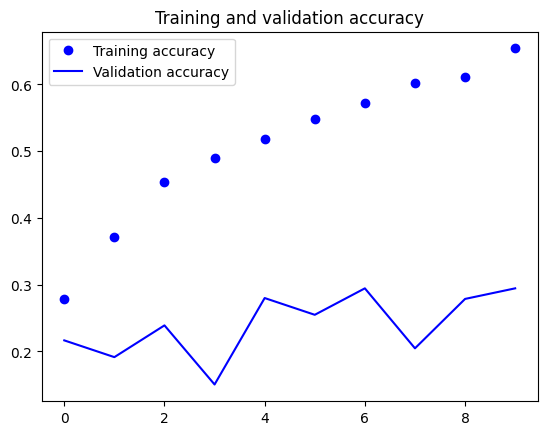

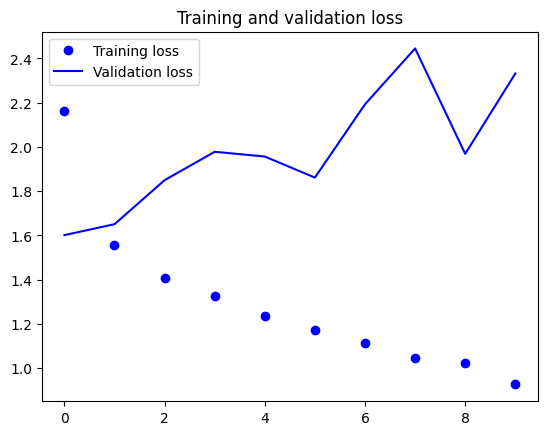

In [16]:
# Evaluamos con el conjunto de validación
test_eval = dbz_model.evaluate(val_gen, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# Extraemos el historial del entrenamiento
accuracy = dbz_train.history['accuracy']
val_accuracy = dbz_train.history['val_accuracy']
loss = dbz_train.history['loss']
val_loss = dbz_train.history['val_loss']

# Graficamos accuracy
epochs_range = range(len(accuracy))
plt.plot(epochs_range, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Graficamos pérdida (loss)
plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


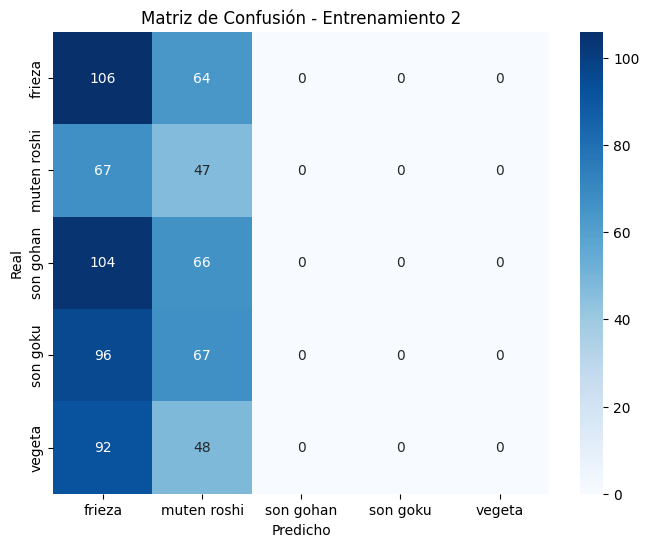

              precision    recall  f1-score   support

      frieza       0.23      0.62      0.33       170
 muten roshi       0.16      0.41      0.23       114
   son gohan       0.00      0.00      0.00       170
    son goku       0.00      0.00      0.00       163
      vegeta       0.00      0.00      0.00       140

    accuracy                           0.20       757
   macro avg       0.08      0.21      0.11       757
weighted avg       0.08      0.20      0.11       757



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicción
y_pred = dbz_model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_gen.class_indices,
            yticklabels=val_gen.class_indices)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Entrenamiento 2')
plt.show()

# Reporte de Clasificación
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))